In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
!pip install lifetimes

     |████████████████████████████████| 584 kB 4.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.spatial.distance import cdist
import datetime, nltk, warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
sns.set_theme(style='whitegrid')
from mpl_toolkits import mplot3d
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
import lifetimes
import datetime as dt

# 1. Discovering dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Essay/online_retail_II.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


**Comment:** 
1. We can see that the datafile has information given for each single transaction. 
2. Take a look at the InvoiceNo and the CustomerID of the first entries. Here we can see that one customer with ID 17850 of the United Kingdom made a single order that has the InvoideNo 536365. => The customer **ordered several products with different stockcodes, descriptions, unit prices and quantities.** In addition we can see that the InvoiceDate was the same for these products.

## Missing values

In [ ]:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
column type,object,object,object,int64,object,float64,float64,object
null values (nb),0,0,4382,0,0,0,243007,0
null values (%),0.0,0.0,0.410541,0.0,0.0,0.0,22.766873,0.0


**Comment**
1. ∼ 23% of the entries are not assigned to a particular customer and  ~ 0.4 % of missing descriptions
2. wrong type at Invoice Date

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.rename(columns = {"Customer ID": "CustomerID"}, inplace = True)

### Missing description

In [ ]:
df[df.Description.isnull()].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.0,NaN,United Kingdom
3114,489655,20683,NaN,-44,2009-12-01 17:26:00,0.0,NaN,United Kingdom
3161,489659,21350,NaN,230,2009-12-01 17:39:00,0.0,NaN,United Kingdom
3731,489781,84292,NaN,17,2009-12-02 11:45:00,0.0,NaN,United Kingdom
4296,489806,18010,NaN,-770,2009-12-02 12:42:00,0.0,NaN,United Kingdom


In [ ]:
# missing description & missing customer id
df[df.Description.isnull()].CustomerID.isnull().value_counts()

True    4382
Name: CustomerID, dtype: int64

In [ ]:
# missing description has unit price ?
df[df.Description.isnull()].Price.value_counts()

0.0    4382
Name: Price, dtype: int64

**Comment:** 

In cases of missing descriptions we always miss the customer and the unit price as well. 

=> It seems that there is no sophisticated procedure how to deal with and record such kind of transactions. 

=> This is already a hint that we could expect strange entries in our data and that it can be **difficult to detect** them!

### Missing Customer IDs

In [ ]:
df[df.CustomerID.isnull()].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom


In [ ]:
df.loc[df.CustomerID.isnull(), ["Price", "Quantity"]].describe()

,Price,Quantity
count,243007.000000,243007.000000
mean,7.948744,1.540548
std,224.275451,98.859370
min,-53594.360000,-9600.000000
25%,1.660000,1.000000
50%,3.290000,1.000000
75%,5.790000,2.000000
max,25111.090000,10200.000000


**Comment**: The price and the quantities of entries without a customer ID can show extreme outliers. 

### Hidden missing descriptions

In [ ]:
df.loc[df.Description.isnull()==False, "lowercase_descriptions"] = df.loc[df.Description.isnull()==False,"Description"].apply(lambda l: l.lower())

In [ ]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,lowercase_descriptions
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,15cm christmas glass ball 20 lights
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,pink cherry lights
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,white cherry lights
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,"record frame 7"" single size"
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,strawberry ceramic trinket box
...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,children's apron dolly girl
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery dolly girl
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery circus parade
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,baking set 9 piece retrospot


In [ ]:
df.lowercase_descriptions.dropna().apply(lambda l: np.where("nan" in l, True, False)).value_counts()

False    1061843
True        1146
Name: lowercase_descriptions, dtype: int64

In [ ]:
df.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

False    1062989
Name: lowercase_descriptions, dtype: int64

**Comment:** We found additional, hidden nan-values that show a string "nan" instead of a nan-value. 

### Cleaning

Let's transform nan them to NaN

In [ ]:
df.loc[df.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = df.loc[
    df.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

As we don't know why customers or descriptions are missing and we have seen **strange outliers in quantities and prices** as well as zero-prices => drop all of these occurences.

In [ ]:
df = df.loc[(df.CustomerID.isnull()==False) & (df.lowercase_descriptions.isnull()==False)].copy()

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df.shape

(823429, 9)

## The time period

In [ ]:
df.InvoiceDate.max() - df.InvoiceDate.min()

Timedelta('738 days 05:05:00')

In [ ]:
print("Datafile starts with timepoint {}".format(df.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(df.InvoiceDate.max()))

Datafile starts with timepoint 2009-12-01 07:45:00
Datafile ends with timepoint 2011-12-09 12:50:00


## The invoice number

In [ ]:
df.Invoice.nunique()

44866

Find that a cancelled transactions starts with a "C" in front of it

In [ ]:
df["IsCancelled"]=np.where(df.Invoice.apply(lambda l: l[0]=="C"), True, False)
df.IsCancelled.value_counts() / df.shape[0] * 100

False    97.725973
True      2.274027
Name: IsCancelled, dtype: float64

~ 2,3 % of all entries are cancellations.

In [ ]:
df.loc[df.IsCancelled==True].describe()

,Quantity,Price,CustomerID
count,18725.000000,18725.000000,18725.000000
mean,-25.989212,23.922300,15014.651162
std,821.456875,424.409299,1698.714561
min,-80995.000000,0.010000,12346.000000
25%,-6.000000,1.450000,13552.000000
50%,-2.000000,2.950000,14911.000000
75%,-1.000000,5.950000,16401.000000
max,-1.000000,38970.000000,18287.000000


**Comment**: 

**All cancellations have negative quantites but positive, non-zero unit prices**. Given this data we are not easily able to understand why a customer made a return and it's very difficult to predict such cases as there could be several, hidden reasons why a cancellation was done =>  Drop them

In [ ]:
df = df.loc[df.IsCancelled==False].copy()
df = df.drop("IsCancelled", axis=1)
df.shape

(804704, 9)

## Stockcodes

In [ ]:
#Unique stockcode
df.StockCode.nunique()

4629

In [ ]:
df.StockCode.value_counts()

85123A    5188
22423     3430
85099B    3360
84879     2777
20725     2678
          ... 
20882        1
84630        1
79301        1
84567        1
23843        1
Name: StockCode, Length: 4629, dtype: int64

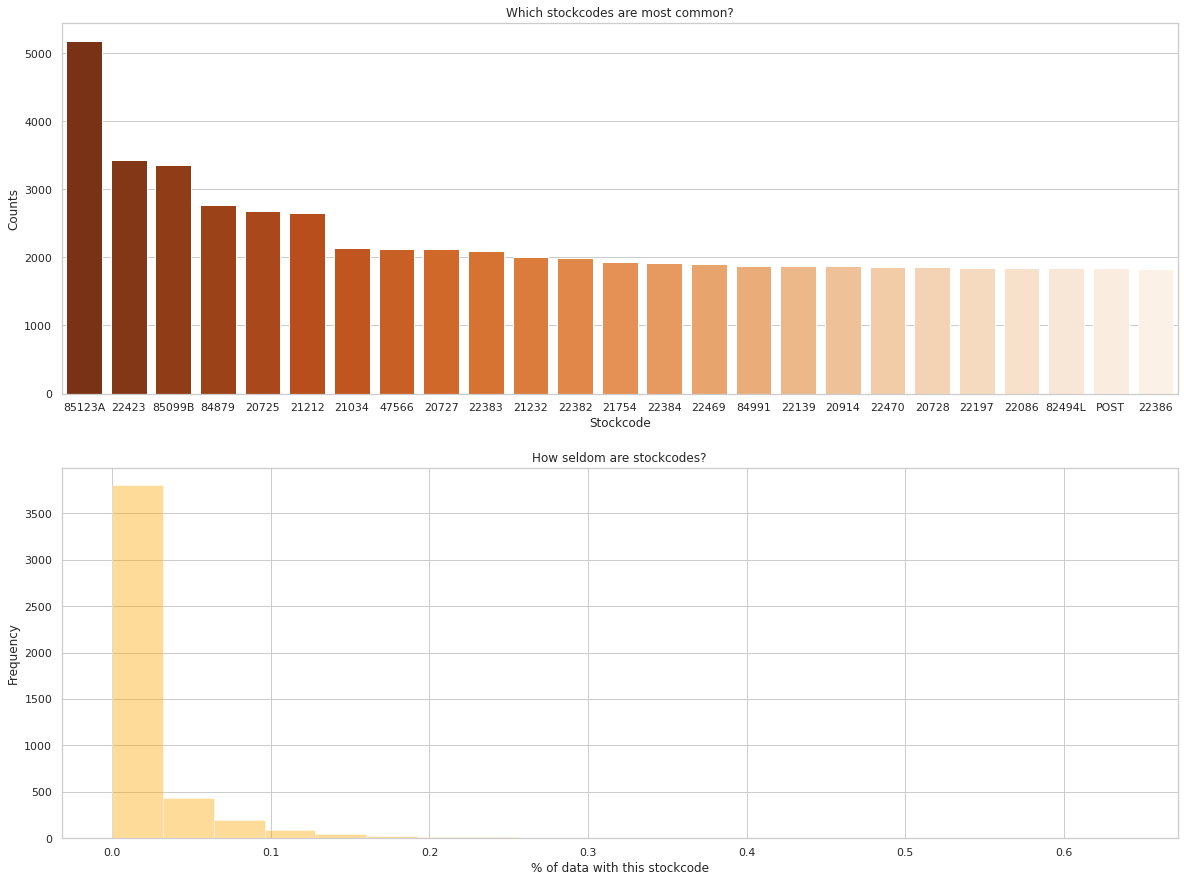

In [ ]:
stockcode_counts = df.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(stockcode_counts.iloc[0:25].index,
            stockcode_counts.iloc[0:25].values,
            ax = ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/df.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

**Comment:** 
1. There is POS in the most common stockcode counts
2. Most stockcodes are very seldom. This indicates that the retailer sells many different products and that there is no strong secialization of a specific stockcode. Nevertheless we have to be careful as this must not mean that the retailer is not specialized given a specific product type. The stockcode could be a very detailed indicator that does not yield information of the type, for example water bottles may have very different variants in color, name and shapes but they are all water bottles.

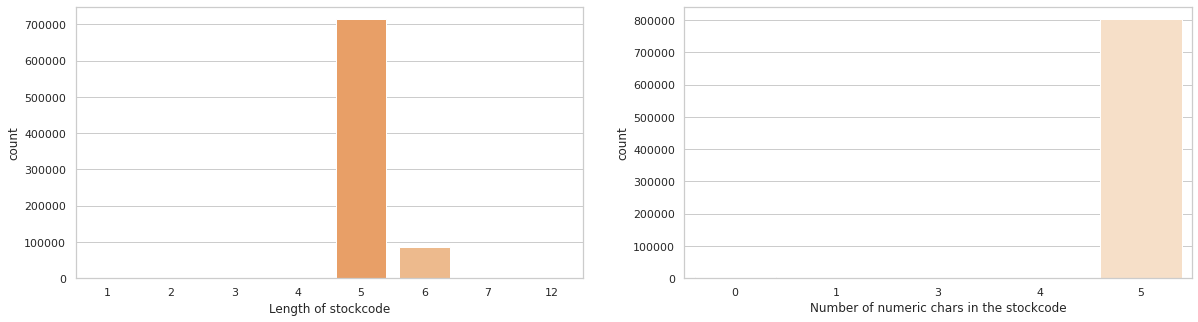

In [ ]:
from locale import D_FMT
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

df["StockCodeLength"] = df.StockCode.apply(lambda l: len(l))
df["nNumericStockCode"] = df.StockCode.apply(lambda l: count_numeric_chars(l))

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(df["StockCodeLength"], palette="Oranges_r", ax=ax[0])
sns.countplot(df["nNumericStockCode"], palette="Oranges_r", ax=ax[1])
ax[0].set_xlabel("Length of stockcode")
ax[1].set_xlabel("Number of numeric chars in the stockcode");

**Nhận xét:** 

Even though the majority of samples has a stockcode that consists of 5 numeric chars, we can see that there are other occurences as well. 

The length can vary between 1 and 12 and there are stockcodes with no numeric chars at all!

In [ ]:
df.loc[df.nNumericStockCode < 5].lowercase_descriptions.value_counts()

postage                                1838
manual                                  716
carriage                                253
bank charges                             30
pads to match all cushions               18
adjustment by john on 26/01/2010 16      18
dotcom postage                           16
adjustment by john on 26/01/2010 17      14
this is a test product.                  12
discount                                  5
adjustment by peter on jun 25 2010        3
 bank charges                             2
kid's chalkboard/easel                    2
Name: lowercase_descriptions, dtype: int64

**Comment:** retailer does not speparate well between special kind of transactions and valid customer-retailer transactions.

In [ ]:
df = df.loc[(df.nNumericStockCode == 5) | (df.StockCodeLength==6)].copy()
df.StockCode.nunique()

4619

In [ ]:
df = df.drop(["nNumericStockCode", "StockCodeLength"], axis=1)
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,lowercase_descriptions
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,15cm christmas glass ball 20 lights
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,pink cherry lights
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,white cherry lights
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,"record frame 7"" single size"
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,strawberry ceramic trinket box
...,...,...,...,...,...,...,...,...,...
1067365,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,pack of 20 spaceboy napkins
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,children's apron dolly girl
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery dolly girl
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery circus parade


## Descriptions

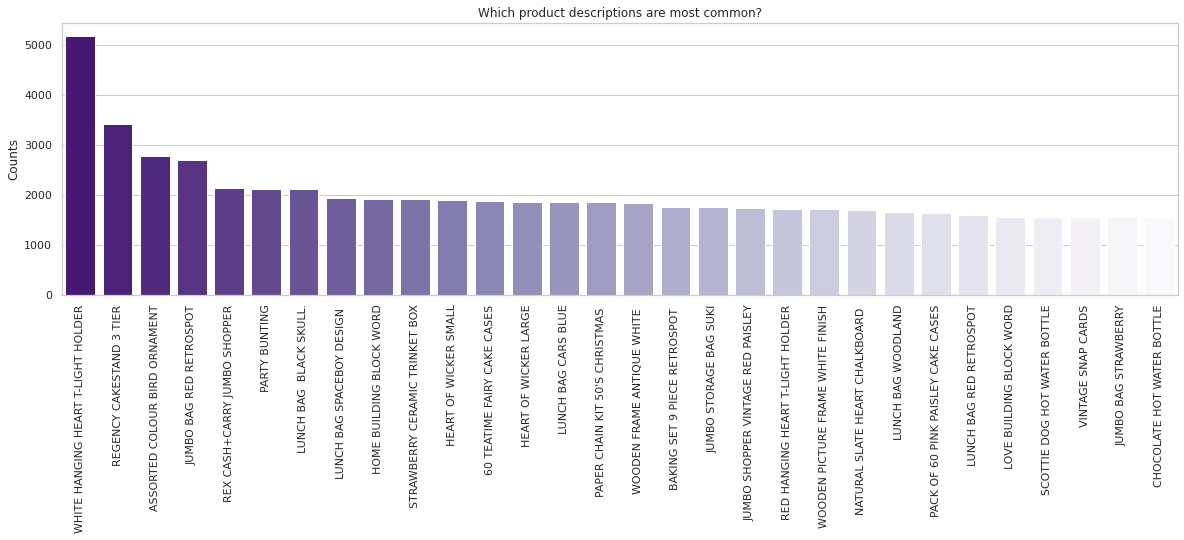

In [ ]:
description_counts = df.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90);

In [ ]:
df.Description.nunique()

5271

Do you see the multiple occurences of lunch bags? We often have color information about the product as well. Furthermore the most common descriptions seem to confirm that the retailer sells various different kinds of products.

In [ ]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())
df["DescriptionLength"] = df.Description.apply(lambda l: len(l))
df["LowCharsInDescription"] = df.Description.apply(lambda l: count_lower_chars(l))
df[df.LowCharsInDescription != 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription
361,489517,21705,BAG 500g SWIRLY MARBLES,1,2009-12-01 11:34:00,1.65,16329.0,United Kingdom,bag 500g swirly marbles,23,1
618,489526,46000S,POLYESTER FILLER PAD 40x40cm,2,2009-12-01 11:50:00,1.45,12533.0,Germany,polyester filler pad 40x40cm,28,3
619,489526,20964,POLYESTER FILLER PAD 60x40cm,3,2009-12-01 11:50:00,2.55,12533.0,Germany,polyester filler pad 60x40cm,28,3
2844,489617,46000P,POLYESTER FILLER PAD 65CMx65CM,2,2009-12-01 14:59:00,4.25,13442.0,United Kingdom,polyester filler pad 65cmx65cm,30,1
2845,489617,46000M,POLYESTER FILLER PAD 45x45cm,4,2009-12-01 14:59:00,1.55,13442.0,United Kingdom,polyester filler pad 45x45cm,28,3
...,...,...,...,...,...,...,...,...,...,...,...
1065557,581467,21703,BAG 125g SWIRLY MARBLES,3,2011-12-08 19:24:00,0.42,13077.0,United Kingdom,bag 125g swirly marbles,23,1
1065620,581469,21704,BAG 250g SWIRLY MARBLES,1,2011-12-08 19:28:00,0.85,14606.0,United Kingdom,bag 250g swirly marbles,23,1
1065742,581475,21705,BAG 500g SWIRLY MARBLES,24,2011-12-09 08:39:00,0.39,13069.0,United Kingdom,bag 500g swirly marbles,23,1
1067073,581514,21705,BAG 500g SWIRLY MARBLES,84,2011-12-09 11:20:00,0.39,17754.0,United Kingdom,bag 500g swirly marbles,23,1


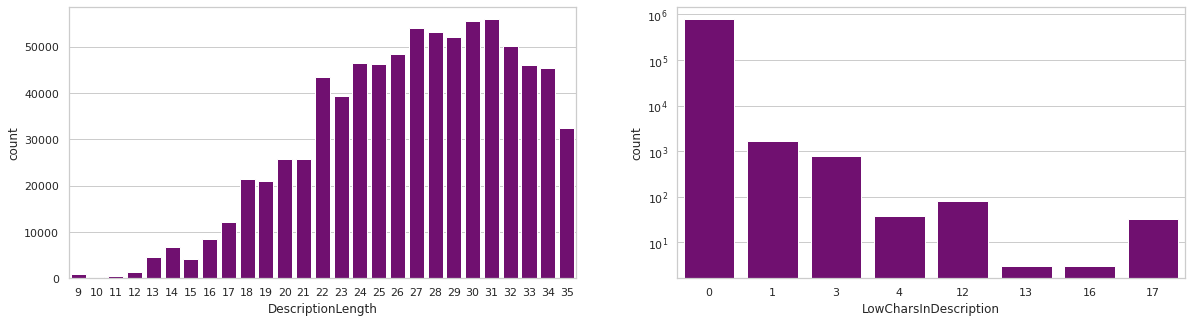

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(df.DescriptionLength, ax=ax[0], color="Purple")
sns.countplot(df.LowCharsInDescription, ax=ax[1], color="Purple")
ax[1].set_yscale("log")

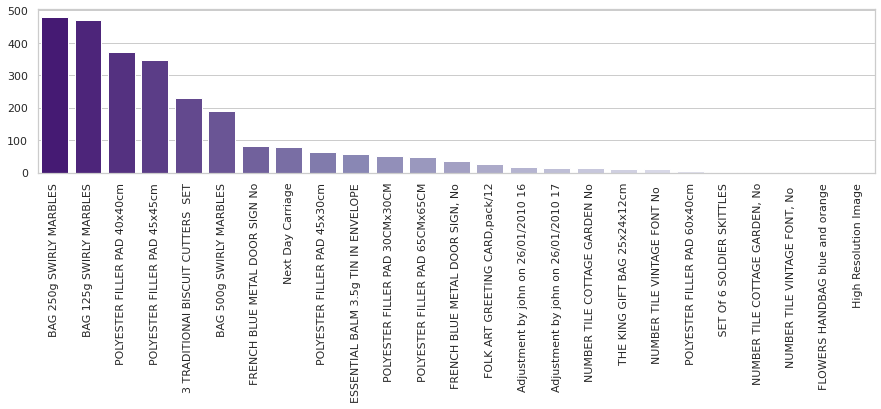

In [ ]:
lowchar_counts = df.loc[df.LowCharsInDescription > 0].Description.value_counts()

plt.figure(figsize=(15,3))
sns.barplot(lowchar_counts.index, lowchar_counts.values, palette="Purples_r")
plt.xticks(rotation=90);

In [ ]:
def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

df["UpCharsInDescription"] = df.Description.apply(lambda l: count_upper_chars(l))
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription,UpCharsInDescription
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,15cm christmas glass ball 20 lights,35,0,26
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,pink cherry lights,18,0,16
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,white cherry lights,20,0,17
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,"record frame 7"" single size",28,0,21
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,strawberry ceramic trinket box,30,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...
1067365,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,pack of 20 spaceboy napkins,27,0,21
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,children's apron dolly girl,28,0,23
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery dolly girl,29,0,25
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery circus parade,31,0,28


In [ ]:
df.loc[df.UpCharsInDescription <=5].Description.value_counts()

Next Day Carriage                      79
Adjustment by john on 26/01/2010 16    18
Adjustment by john on 26/01/2010 17    14
High Resolution Image                   3
Name: Description, dtype: int64

In [ ]:
df = df.loc[df.UpCharsInDescription > 5].copy()

In [ ]:
df.StockCode.nunique()

4616

In [ ]:
df.StockCode.nunique()

4616

## Customers

In [ ]:
df.CustomerID.nunique()

5853

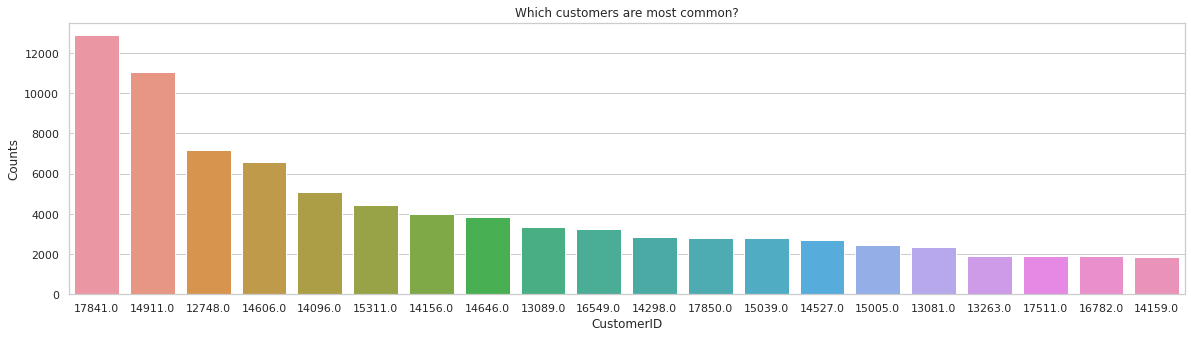

In [ ]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);


## Countries

In [ ]:
df.Country.nunique()

41

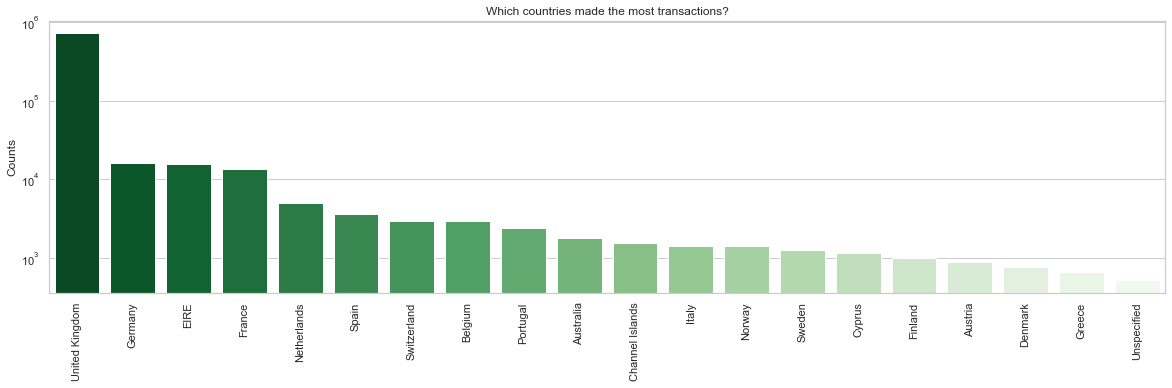

In [ ]:
country_counts = df.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values, palette="Greens_r")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

**Comment:**  We can see that the retailer sells almost all products in the UK, followed by many european countries

In [ ]:
df.loc[df.Country=="United Kingdom"].shape[0] / df.shape[0] * 100

90.25080547887792

## Unit Price

In [ ]:
df.Price.describe()

count    801697.000000
mean          2.930778
std           4.276444
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: Price, dtype: float64

zero unit prices!

In [ ]:
df.loc[df.Price == 0].sort_values(by="Quantity", ascending=False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription,UpCharsInDescription,UK
1027583,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom,asstd design 3d paper stickers,30,0,25,1
358820,524181,46000M,POLYESTER FILLER PAD 45x45cm,648,2010-09-27 16:59:00,0.0,17450.0,United Kingdom,polyester filler pad 45x45cm,28,3,18,1
823515,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.0,14911.0,EIRE,set of 6 nativity magnets,26,0,20,0
961889,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,2011-11-03 11:26:00,0.0,12415.0,Australia,biscuit tin vintage christmas,29,0,26,0
840207,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646.0,Netherlands,set of 2 ceramic christmas reindeer,35,0,29,0


It's not obvious if they are gifts to customers or not 

In [ ]:
#df = df.loc[df.Price > 0].copy()

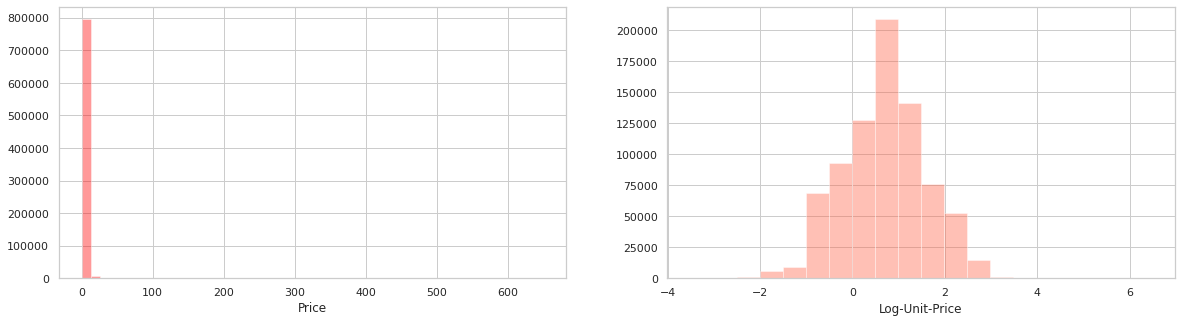

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(df.Price, ax=ax[0], kde=False, color="red")
sns.distplot(np.log(df.Price), ax=ax[1], bins=20, color="tomato", kde=False)
ax[1].set_xlabel("Log-Unit-Price");

**Comment:**
Let's focus transactions with prices that fall into this range as we don't want to make predictions for very seldom products with high prices

In [ ]:
#df = df.loc[(df.Price > np.round(np.exp(-2),1)) & (df.Price < np.round(np.exp(3),1))].copy()

## Quantities

In [ ]:
df.Quantity.describe()

count    799805.000000
mean         13.001010
std         136.017288
min           1.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

Most products are sold in quantities from 1 to 12. But, we have extreme, unrealistic outliers

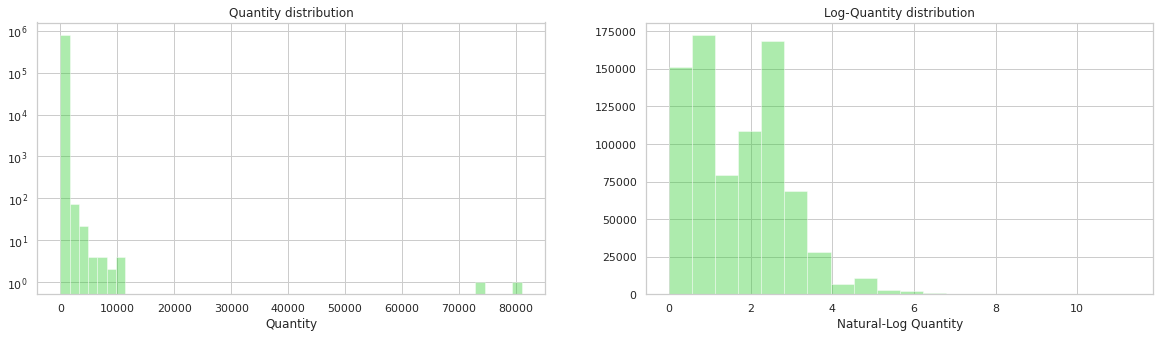

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(df.Quantity, ax=ax[0], kde=False, color="limegreen");
sns.distplot(np.log(df.Quantity), ax=ax[1], bins=20, kde=False, color="limegreen");
ax[0].set_title("Quantity distribution")
ax[0].set_yscale("log")
ax[1].set_title("Log-Quantity distribution")
ax[1].set_xlabel("Natural-Log Quantity");

As you can see by the log-transformed distribution it would make sense to make a cut

In [ ]:
df = df.loc[df.Quantity < np.round(np.exp(4))].copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription,UpCharsInDescription,UK
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,15cm christmas glass ball 20 lights,35,0,26,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,pink cherry lights,18,0,16,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,white cherry lights,20,0,17,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,"record frame 7"" single size",28,0,21,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,strawberry ceramic trinket box,30,0,27,1


# 2. Data Preprocessing

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Essay/online_retail_II.csv')
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
def cleaning(df):
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
  # df['Customer ID'] = df['Customer ID'].astype('int64')
  df.rename(columns = {"Customer ID": "CustomerID"}, inplace = True)

  df.loc[df.Description.isnull()==False, "lowercase_descriptions"] = df.loc[df.Description.isnull()==False,"Description"].apply(lambda l: l.lower())
  df.loc[df.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = df.loc[df.lowercase_descriptions.isnull()==False, "lowercase_descriptions"].apply(lambda l: np.where("nan" in l, None, l))
  df = df.loc[(df.CustomerID.isnull()==False) & (df.lowercase_descriptions.isnull()==False)].copy()

  df["IsCancelled"]=np.where(df.Invoice.apply(lambda l: l[0]=="C"), True, False)
  df = df.loc[df.IsCancelled==False].copy()
  df = df.drop("IsCancelled", axis=1)

  def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

  df["StockCodeLength"] = df.StockCode.apply(lambda l: len(l))
  df["nNumericStockCode"] = df.StockCode.apply(lambda l: count_numeric_chars(l))
  df = df.loc[(df.nNumericStockCode == 5) | (df.StockCodeLength==6)].copy()
  df = df.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

  def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

  df["UpCharsInDescription"] = df.Description.apply(lambda l: count_upper_chars(l))
  df = df.loc[df.UpCharsInDescription > 5].copy()
  df = df.drop(["lowercase_descriptions", "UpCharsInDescription"], axis=1)

  df = df.loc[(df.Price > np.round(np.exp(-2),1)) & (df.Price < np.round(np.exp(3),1))].copy()
  df = df.loc[df.Quantity < np.round(np.exp(4))].copy()

  df['TotalValue'] = df.Quantity * df.Price
  df['year'] = pd.DatetimeIndex(df.InvoiceDate).year
  df['month'] = pd.DatetimeIndex(df.InvoiceDate).month
  df['day'] = pd.DatetimeIndex(df.InvoiceDate).day
  df['hour'] = pd.DatetimeIndex(df.InvoiceDate).hour
  df['year_month'] = df.year.astype('string') +'-'+ df.month.astype('string')
  return df

In [ ]:
data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
data = cleaning(data)

In [ ]:
gdp2010 = ({'United Kingdom': 39689, 'France': 40638, 'USA': 48467, 'Belgium': 44142, 'Australia': 52088,
           'EIRE': 48608, 'Germany': 41532, 'Portugal': 22499, 'Japan': 44968, 'Denmark': 58041, 'Nigeria': 2280,
           'Netherlands': 50950, 'Poland': 12613, 'Spain': 30503, 'Channel Islands': 0, 'Italy': 36001, 'Cyprus': 31024,
           'Greece': 26691, 'Norway': 87694, 'Austria': 46858, 'Sweden': 52869, 'United Arab Emirates': 33893,
           'Finland': 46460, 'Switzerland': 77117, 'Unspecified': 0, 'Malta': 21799, 'Bahrain': 20722, 'RSA': 8149,
           'Bermuda': 101875, 'Hong Kong': 32550, 'Singapore': 47237, 'Thailand': 5076, 'Israel': 30780, 'Lithuania': 11988,
           'West Indies': 0, 'Lebanon': 7762, 'Korea': 23087, 'Brazil': 11286, 'Canada': 47562, 'Iceland': 43237,
           'Saudi Arabia': 19263, 'Czech Republic': 19960, 'European Community': 32943})

gdp2011 = ({'United Kingdom': 42285, 'France': 43791, 'USA': 49883, 'Belgium': 47349, 'Australia': 62574,
           'EIRE': 52109, 'Germany': 46645, 'Portugal': 23187, 'Japan': 48760, 'Denmark': 61754, 'Nigeria': 2488,
           'Netherlands': 54159, 'Poland': 13880, 'Spain': 31636, 'Channel Islands': 0, 'Italy': 38599, 'Cyprus': 32396,
           'Greece': 25451, 'Norway': 100601, 'Austria': 51375, 'Sweden': 60756, 'United Arab Emirates': 39195,
           'Finland': 51082, 'Switzerland': 91254, 'Unspecified': 0, 'Malta': 23156, 'Bahrain': 22514, 'RSA': 8811,
           'Bermuda': 97774, 'Hong Kong': 35142, 'Singapore': 53890, 'Thailand': 5492, 'Israel': 33776, 'Lithuania': 14377,
           'West Indies': 0, 'Lebanon': 7675, 'Korea': 25096, 'Brazil': 13245, 'Canada': 52224, 'Iceland': 47715,
           'Saudi Arabia': 23746, 'Czech Republic': 21871, 'European Community': 35716})

In [ ]:
def get_features(input):
    df = input.copy(deep=True)
    total_invoice = df.groupby(['CustomerID']).Invoice.nunique()
    avg_invoice = total_invoice / df.groupby(['CustomerID']).year_month.nunique()
    n_invoice_month = df.groupby(['CustomerID', 'year_month']).Invoice.nunique().reset_index()
    min_invoice =  n_invoice_month.groupby(['CustomerID']).Invoice.min()
    max_invoice = n_invoice_month.groupby(['CustomerID']).Invoice.max()
    a = df.groupby(['CustomerID', 'year_month']).Invoice.nunique()
    std_invoice = a.groupby(['CustomerID']).std()

    money_by_month = df.groupby(['CustomerID', 'year_month']).TotalValue.sum().reset_index()
    avg_money = money_by_month.groupby(['CustomerID']).TotalValue.sum() / money_by_month.groupby(['CustomerID']).year_month.nunique()
    min_money = money_by_month.groupby(['CustomerID']).TotalValue.min()
    max_money = money_by_month.groupby(['CustomerID']).TotalValue.max()
    b = df.groupby(['CustomerID', 'year_month']).TotalValue.sum()
    std_money = b.groupby(['CustomerID']).std()
    total_product = df.groupby(['CustomerID']).StockCode.nunique()
    avg_product = total_product / df.groupby(['CustomerID']).year_month.nunique()

    end_date = df['InvoiceDate'].max()
    snapshot_date = end_date + datetime.timedelta(days=1)

    recency = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days}).InvoiceDate
    frequency = df.groupby(['CustomerID']).agg({'Invoice': 'count'}).Invoice
    monetary = df.groupby(['CustomerID']).TotalValue.sum()

    mode_hour = df.groupby(['CustomerID']).hour.value_counts().unstack().idxmax(axis=1)
    avg_product_month = df.groupby(['CustomerID']).StockCode.nunique() / df.groupby(['CustomerID']).year_month.nunique()
    max_product = df.groupby(['CustomerID']).StockCode.value_counts().unstack().idxmax(axis=1)

    avg_sale = df.groupby(['CustomerID', 'Invoice']).TotalValue.sum().reset_index().groupby(['CustomerID']).TotalValue.mean()

    gdp = df.groupby(['CustomerID']).Country.value_counts().unstack().idxmax(axis=1)
    if df.year.iloc[0] == 2010:
        gdp.replace(gdp2010, inplace=True)
    elif df.year.iloc[0] == 2011:
        gdp.replace(gdp2011, inplace=True)



    features = pd.DataFrame({'total_invoice':total_invoice, 'avg_invoice':avg_invoice, 'min_invoice':min_invoice,
                             'max_invoice':max_invoice, 'std_invoice':std_invoice, 'avg_money':avg_money, 'min_money':min_money,
                             'max_money':max_money, 'std_money':std_money, 'total_product':total_product, 'avg_product':avg_product,
                             'recency':recency, 'frequency':frequency, 'monetary_value':monetary, 'mode_hour':mode_hour,
                             'avg_product_month':avg_product_month, 'avg_sale':avg_sale, 'gdp': gdp
                             })
    return features

In [ ]:
def feature_scaling(dataframe):
    df = dataframe.copy(deep=True)
    for col in df.columns:
        df[col] = df[col].apply(lambda x: np.log(x+0.001))
    df = df.fillna(0)
    normalized_df = MinMaxScaler().fit_transform(df)
    return normalized_df

In [ ]:
df = cleaning(data)
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalValue,year,month,day,hour,year_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,2009,12,1,7,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009,12,1,7,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009,12,1,7,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,2009,12,1,7,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,2009,12,1,7,2009-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067365,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011,12,9,12,2011-12
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011,12,9,12,2011-12
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,9,12,2011-12
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,9,12,2011-12


# 3. RFM + CLV

## RFM

In [ ]:
tx_2010 = df.loc[(df.InvoiceDate < pd.datetime(2011,1,1)) & (df.InvoiceDate >= pd.datetime(2010,1,1))].reset_index(drop=True)
tx_2011 = df.loc[(df.InvoiceDate >= pd.datetime(2011,1,1)) & (df.InvoiceDate < pd.datetime(2011,12,1))].reset_index(drop=True)
tx_2010

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalValue,year,month,day,hour,year_month
0,493414,21844,RETRO SPOT MUG,36,2010-01-04 10:28:00,2.55,14590.0,United Kingdom,91.80,2010,1,4,10,2010-1
1,493414,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-04 10:28:00,4.25,14590.0,United Kingdom,51.00,2010,1,4,10,2010-1
2,493414,37508,NEW ENGLAND CERAMIC CAKE SERVER,2,2010-01-04 10:28:00,2.55,14590.0,United Kingdom,5.10,2010,1,4,10,2010-1
3,493414,35001G,HAND OPEN SHAPE GOLD,2,2010-01-04 10:28:00,4.25,14590.0,United Kingdom,8.50,2010,1,4,10,2010-1
4,493414,21527,RETRO SPOT TRADITIONAL TEAPOT,12,2010-01-04 10:28:00,6.95,14590.0,United Kingdom,83.40,2010,1,4,10,2010-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389079,539988,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,1,2010-12-23 16:06:00,1.25,18116.0,United Kingdom,1.25,2010,12,23,16,2010-12
389080,539988,84849D,HOT BATHS SOAP HOLDER,1,2010-12-23 16:06:00,1.69,18116.0,United Kingdom,1.69,2010,12,23,16,2010-12
389081,539988,84849B,FAIRY SOAP SOAP HOLDER,1,2010-12-23 16:06:00,1.69,18116.0,United Kingdom,1.69,2010,12,23,16,2010-12
389082,539988,22854,CREAM SWEETHEART EGG HOLDER,2,2010-12-23 16:06:00,4.95,18116.0,United Kingdom,9.90,2010,12,23,16,2010-12


In [ ]:
tx_2011

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalValue,year,month,day,hour,year_month
0,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,19.50,2011,1,4,10,2011-1
1,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.50,2011,1,4,10,2011-1
2,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.50,2011,1,4,10,2011-1
3,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom,10.50,2011,1,4,10,2011-1
4,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom,12.50,2011,1,4,10,2011-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341332,579885,85034C,3 ROSE MORRIS BOXED CANDLES,4,2011-11-30 17:37:00,1.25,15444.0,United Kingdom,5.00,2011,11,30,17,2011-11
341333,579885,21742,LARGE ROUND WICKER PLATTER,2,2011-11-30 17:37:00,5.95,15444.0,United Kingdom,11.90,2011,11,30,17,2011-11
341334,579885,23084,RABBIT NIGHT LIGHT,6,2011-11-30 17:37:00,2.08,15444.0,United Kingdom,12.48,2011,11,30,17,2011-11
341335,579885,21257,VICTORIAN SEWING BOX MEDIUM,1,2011-11-30 17:37:00,7.95,15444.0,United Kingdom,7.95,2011,11,30,17,2011-11


In [ ]:
#create tx_user for assigning clustering
tx_user = pd.DataFrame(tx_2010['CustomerID'].unique())
tx_user.columns = ['Customer ID']
tx_user

,Customer ID
0,14590.0
1,13287.0
2,16550.0
3,14680.0
4,14709.0
...,...
4125,16270.0
4126,12515.0
4127,12383.0
4128,13817.0


In [ ]:
def create_rfm(dataframe):

    # CALCULATION OF RFM metrics
    today_date = dt.datetime(2011, 12, 9)
    rfm = dataframe.groupby('CustomerID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                                'Invoice': lambda num: num.nunique(),
                                                "TotalValue": lambda price: price.sum()})
    rfm.columns = ['recency', 'frequency', "monetary"]
    rfm = rfm[(rfm['monetary'] > 0)]

    # CALCULATION OF RFM SCORES
    rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
    rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

    # cltv_df scores converted to categorical value and added to df
    rfm["RFM_SCORE"] = rfm['recency_score'].astype(int)+rfm['frequency_score'].astype(int)+rfm['monetary_score'].astype(int)
    rfm = rfm.sort_values(by="RFM_SCORE", ascending=True)
    rfm["segment"] = pd.qcut(rfm["RFM_SCORE"], 3, labels=["Low","Middle","High"])
    return rfm

rfm = create_rfm(tx_2010)
rfm

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
CustomerID,,,,,,,,
14378.0,620,1,131.25,1,1,1,3,Low
14726.0,653,1,124.75,1,1,1,3,Low
14694.0,616,1,229.19,1,1,1,3,Low
12717.0,589,1,227.93,1,1,1,3,Low
14683.0,587,1,131.26,1,1,1,3,Low
...,...,...,...,...,...,...,...,...
13448.0,363,7,5011.24,5,5,5,15,High
17068.0,357,28,4892.64,5,5,5,15,High
17069.0,353,6,3167.23,5,5,5,15,High


In [ ]:
rfm1=create_rfm(tx_2011)
rfm1

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
CustomerID,,,,,,,,
14238.0,325,1,146.85,1,1,1,3,Low
12574.0,314,1,182.45,1,1,1,3,Low
15388.0,269,1,140.54,1,1,1,3,Low
13649.0,255,1,148.80,1,1,1,3,Low
13618.0,172,1,177.34,1,1,1,3,Low
...,...,...,...,...,...,...,...,...
14701.0,9,9,2130.32,5,5,5,15,High
14702.0,17,14,2643.86,5,5,5,15,High
14709.0,14,12,4606.94,5,5,5,15,High


In [ ]:
rfm_churn=rfm[rfm.index.isin(rfm1.index)==False]
print(len(rfm_churn))
rfm_newcus=rfm1[rfm1.index.isin(rfm.index)==False]
print(len(rfm_newcus))
rfm_high=rfm[rfm['segment']=='High']
rfm1_high=rfm1[rfm1['segment']=='High']

1543
1503


In [ ]:
churn_high=rfm_churn[rfm_churn['segment']=="High"]
print(len(churn_high),churn_high.monetary.sum())
new_high=rfm_newcus[rfm_newcus['segment']=="High"]
print(len(new_high),new_high.monetary.sum())


113 273418.31
330 638422.4400000001


In [ ]:
churn_rate=(len(churn_high))/((len(rfm_high)+len(rfm1_high))/2)*100
churn_rate

8.862745098039216

In [ ]:
churn_rate2=(len(rfm_churn))/((len(rfm)+len(rfm1))/2)*100
churn_rate2

37.54257907542579

In [ ]:
#top10 high value customer buy most
rfm_high['monetary'].nlargest(n=10)

CustomerID
14911.0    131226.55
14156.0     53419.57
13089.0     50232.76
17850.0     47973.44
14646.0     45024.58
13093.0     37694.12
17511.0     34884.86
14298.0     34395.85
15311.0     31050.53
17841.0     26593.69
Name: monetary, dtype: float64

In [ ]:
rfm["segment"].value_counts()

Middle    1491
Low       1452
High      1187
Name: segment, dtype: int64

## CLV

In [ ]:
# Creating the summary data using summary_data_from_transaction_data function
summary = lifetimes.utils.summary_data_from_transaction_data(tx_2010, 'CustomerID', 'InvoiceDate', 'TotalValue' )
summary = summary.reset_index()
summary

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,1.0,118.0,296.0,142.310
1,12347.0,1.0,37.0,53.0,1423.580
2,12348.0,1.0,80.0,87.0,163.200
3,12349.0,1.0,182.0,238.0,1152.620
4,12351.0,0.0,0.0,24.0,0.000
...,...,...,...,...,...
4125,18283.0,4.0,276.0,307.0,135.105
4126,18284.0,0.0,0.0,80.0,0.000
4127,18285.0,0.0,0.0,309.0,0.000
4128,18286.0,0.0,0.0,125.0,0.000


In [ ]:
# Fitting the BG/NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.0001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 4130 subjects, a: 0.00, alpha: 74.12, b: 0.00, r: 0.89>

In [ ]:
# Model summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,8.860331e-01,3.003519e-02,8.271641e-01,9.449021e-01
alpha,7.411988e+01,2.856601e+00,6.852094e+01,7.971881e+01
a,2.694024e-13,3.216652e-09,-6.304369e-09,6.304908e-09
b,6.609877e-05,7.869451e-01,-1.542346e+00,1.542478e+00


In [ ]:
# Compute the customer alive probability
summary['probability_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])
summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive
0,12346.0,1.0,118.0,296.0,142.310,1.0
1,12347.0,1.0,37.0,53.0,1423.580,1.0
2,12348.0,1.0,80.0,87.0,163.200,1.0
3,12349.0,1.0,182.0,238.0,1152.620,1.0
4,12351.0,0.0,0.0,24.0,0.000,1.0
...,...,...,...,...,...,...
4125,18283.0,4.0,276.0,307.0,135.105,1.0
4126,18284.0,0.0,0.0,80.0,0.000,1.0
4127,18285.0,0.0,0.0,309.0,0.000,1.0
4128,18286.0,0.0,0.0,125.0,0.000,1.0


In [ ]:
#Predict future transaction for the next 30 days based on historical dataa
t = 30
summary['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T']),2)
summary.sort_values(by='pred_num_txn', ascending=False).reset_index()

,index,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,1762,14911.0,119.0,350.0,350.0,1083.008824,1.0,8.48
1,2042,15311.0,100.0,352.0,352.0,300.699000,1.0,7.10
2,243,12748.0,90.0,343.0,343.0,220.335000,1.0,6.54
3,1539,14606.0,88.0,351.0,352.0,198.539659,1.0,6.26
4,3820,17841.0,79.0,349.0,353.0,333.623671,1.0,5.61
...,...,...,...,...,...,...,...,...
4125,2084,15375.0,0.0,0.0,339.0,0.000000,1.0,0.06
4126,1802,14969.0,0.0,0.0,352.0,0.000000,1.0,0.06
4127,4016,18115.0,0.0,0.0,346.0,0.000000,1.0,0.06
4128,3475,17352.0,0.0,0.0,345.0,0.000000,1.0,0.06


In [ ]:
summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,12346.0,1.0,118.0,296.0,142.310,1.0,0.15
1,12347.0,1.0,37.0,53.0,1423.580,1.0,0.45
2,12348.0,1.0,80.0,87.0,163.200,1.0,0.35
3,12349.0,1.0,182.0,238.0,1152.620,1.0,0.18
4,12351.0,0.0,0.0,24.0,0.000,1.0,0.27
...,...,...,...,...,...,...,...
4125,18283.0,4.0,276.0,307.0,135.105,1.0,0.38
4126,18284.0,0.0,0.0,80.0,0.000,1.0,0.17
4127,18285.0,0.0,0.0,309.0,0.000,1.0,0.07
4128,18286.0,0.0,0.0,125.0,0.000,1.0,0.13


In [ ]:
# Checking the relationship between frequency and monetary_value
return_customers_summary = summary[summary['frequency']>0]
print(return_customers_summary.shape)
return_customers_summary

(2667, 7)


,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,12346.0,1.0,118.0,296.0,142.310,1.0,0.15
1,12347.0,1.0,37.0,53.0,1423.580,1.0,0.45
2,12348.0,1.0,80.0,87.0,163.200,1.0,0.35
3,12349.0,1.0,182.0,238.0,1152.620,1.0,0.18
5,12352.0,1.0,17.0,41.0,200.050,1.0,0.49
...,...,...,...,...,...,...,...
4117,18272.0,2.0,97.0,294.0,336.200,1.0,0.24
4119,18276.0,3.0,206.0,247.0,267.230,1.0,0.36
4120,18277.0,2.0,97.0,143.0,366.265,1.0,0.40
4125,18283.0,4.0,276.0,307.0,135.105,1.0,0.38


In [ ]:
# Checking the relationship between frequency and monetary_value
return_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.083761
monetary_value,0.083761,1.000000


In [ ]:
# Modeling the monetary value using Gamma-Gamma Model
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(return_customers_summary['frequency'],
       return_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2667 subjects, p: 11.61, q: 0.89, v: 11.57>

In [ ]:
# Calculating the conditional expected average profit for each customer per transaction
summary = summary[summary['monetary_value'] >0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],
                                       summary['monetary_value'])
summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
0,12346.0,1.0,118.0,296.0,142.310,1.0,0.15,155.388460
1,12347.0,1.0,37.0,53.0,1423.580,1.0,0.45,1449.196784
2,12348.0,1.0,80.0,87.0,163.200,1.0,0.35,176.482886
3,12349.0,1.0,182.0,238.0,1152.620,1.0,0.18,1175.585209
5,12352.0,1.0,17.0,41.0,200.050,1.0,0.49,213.693495
...,...,...,...,...,...,...,...,...
4117,18272.0,2.0,97.0,294.0,336.200,1.0,0.24,343.651460
4119,18276.0,3.0,206.0,247.0,267.230,1.0,0.36,271.966072
4120,18277.0,2.0,97.0,143.0,366.265,1.0,0.40,373.862850
4125,18283.0,4.0,276.0,307.0,135.105,1.0,0.38,138.333294


In [ ]:
# Checking the expected average value and the actual average value in the data to make sure the values are good
print(f"Expected Average Sales: {summary['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {summary['monetary_value'].mean()}")

Expected Average Sales: 375.1346489709792
Actual Average Sales: 367.43274993064404


In [ ]:
# Predicting Customer Lifetime Value for the next 30 days
summary['predicted_clv'] = ggf.customer_lifetime_value(bgf,
                                                               summary['frequency'],
                                                               summary['recency'],
                                                               summary['T'],
                                                               summary['monetary_value'],
                                                               time=1,     # lifetime in months
                                                               freq='D',   # frequency in which the data is present(T)
                                                               discount_rate=0.01) # discount rate
summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv
0,12346.0,1.0,118.0,296.0,142.310,1.0,0.15,155.388460,23.519362
1,12347.0,1.0,37.0,53.0,1423.580,1.0,0.45,1449.196784,638.650250
2,12348.0,1.0,80.0,87.0,163.200,1.0,0.35,176.482886,61.362446
3,12349.0,1.0,182.0,238.0,1152.620,1.0,0.18,1175.585209,210.999717
5,12352.0,1.0,17.0,41.0,200.050,1.0,0.49,213.693495,103.989664
...,...,...,...,...,...,...,...,...,...
4117,18272.0,2.0,97.0,294.0,336.200,1.0,0.24,343.651460,80.025816
4119,18276.0,3.0,206.0,247.0,267.230,1.0,0.36,271.966072,97.758362
4120,18277.0,2.0,97.0,143.0,366.265,1.0,0.40,373.862850,147.609367
4125,18283.0,4.0,276.0,307.0,135.105,1.0,0.38,138.333294,52.677045


In [ ]:
summary['manual_predicted_clv'] = summary['pred_num_txn'] * summary['exp_avg_sales']
summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
0,12346.0,1.0,118.0,296.0,142.310,1.0,0.15,155.388460,23.519362,23.308269
1,12347.0,1.0,37.0,53.0,1423.580,1.0,0.45,1449.196784,638.650250,652.138553
2,12348.0,1.0,80.0,87.0,163.200,1.0,0.35,176.482886,61.362446,61.769010
3,12349.0,1.0,182.0,238.0,1152.620,1.0,0.18,1175.585209,210.999717,211.605338
5,12352.0,1.0,17.0,41.0,200.050,1.0,0.49,213.693495,103.989664,104.709813
...,...,...,...,...,...,...,...,...,...,...
4117,18272.0,2.0,97.0,294.0,336.200,1.0,0.24,343.651460,80.025816,82.476350
4119,18276.0,3.0,206.0,247.0,267.230,1.0,0.36,271.966072,97.758362,97.907786
4120,18277.0,2.0,97.0,143.0,366.265,1.0,0.40,373.862850,147.609367,149.545140
4125,18283.0,4.0,276.0,307.0,135.105,1.0,0.38,138.333294,52.677045,52.566652


In [ ]:
summary['segment'] = pd.qcut(summary['predicted_clv'], 2, labels=["Low","High"])
summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,segment
0,12346.0,1.0,118.0,296.0,142.310,1.0,0.15,155.388460,23.519362,23.308269,Low
1,12347.0,1.0,37.0,53.0,1423.580,1.0,0.45,1449.196784,638.650250,652.138553,High
2,12348.0,1.0,80.0,87.0,163.200,1.0,0.35,176.482886,61.362446,61.769010,Low
3,12349.0,1.0,182.0,238.0,1152.620,1.0,0.18,1175.585209,210.999717,211.605338,High
5,12352.0,1.0,17.0,41.0,200.050,1.0,0.49,213.693495,103.989664,104.709813,Low
...,...,...,...,...,...,...,...,...,...,...,...
4117,18272.0,2.0,97.0,294.0,336.200,1.0,0.24,343.651460,80.025816,82.476350,Low
4119,18276.0,3.0,206.0,247.0,267.230,1.0,0.36,271.966072,97.758362,97.907786,Low
4120,18277.0,2.0,97.0,143.0,366.265,1.0,0.40,373.862850,147.609367,149.545140,High
4125,18283.0,4.0,276.0,307.0,135.105,1.0,0.38,138.333294,52.677045,52.566652,Low


## RFM + CLV

In [ ]:
rfm

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
CustomerID,,,,,,,,
14378.0,620,1,131.25,1,1,1,3,Low
14726.0,653,1,124.75,1,1,1,3,Low
14694.0,616,1,229.19,1,1,1,3,Low
12717.0,589,1,227.93,1,1,1,3,Low
14683.0,587,1,131.26,1,1,1,3,Low
...,...,...,...,...,...,...,...,...
13448.0,363,7,5011.24,5,5,5,15,High
17068.0,357,28,4892.64,5,5,5,15,High
17069.0,353,6,3167.23,5,5,5,15,High


In [ ]:
rfm["segment"].value_counts()

Low       1592
Middle    1351
High      1187
Name: segment, dtype: int64

In [ ]:
summary["segment"].value_counts()

Low     1334
High    1333
Name: segment, dtype: int64

In [ ]:
data = rfm.merge(summary[['segment','CustomerID']], on="CustomerID", how="left")
data.rename(columns = {'segment_x':'segment_rfm','segment_y':'segment_clv'}, inplace = True)
data = data.dropna()
data

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment_rfm,segment_clv
259,13442.0,666,2,175.92,1,2,1,4,Low,Low
270,13223.0,571,2,201.12,1,2,1,4,Low,Low
295,13619.0,543,2,230.19,1,2,1,4,Low,Low
306,13190.0,543,2,166.10,1,2,1,4,Low,Low
397,14279.0,519,2,191.86,1,2,1,4,Low,Low
...,...,...,...,...,...,...,...,...,...,...
4125,13448.0,363,7,5011.24,5,5,5,15,High,High
4126,17068.0,357,28,4892.64,5,5,5,15,High,High
4127,17069.0,353,6,3167.23,5,5,5,15,High,High
4128,14907.0,359,11,3607.98,5,5,5,15,High,High


In [ ]:
conditions = [
    (data['segment_rfm'] == "Low") & (data['segment_clv']=="Low"),
    (data['segment_rfm'] == "Low") & (data['segment_clv']=="High"),
    (data['segment_rfm'] =="Middle") & (data['segment_clv']=="Low"),
    (data['segment_rfm'] =="Middle") & (data['segment_clv']=="High"),
    (data['segment_rfm'] =="High") & (data['segment_clv']=="Low"),
    (data['segment_rfm'] =="High") & (data['segment_clv']=="High")
]

choices = ['low value', 'potential value', 'middle value', 'moderate loyalty','high value','extremely important']
data['segment'] = np.select(conditions, choices)

In [ ]:
data

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment_rfm,segment_clv,segment
259,13442.0,666,2,175.92,1,2,1,4,Low,Low,low value
270,13223.0,571,2,201.12,1,2,1,4,Low,Low,low value
295,13619.0,543,2,230.19,1,2,1,4,Low,Low,low value
306,13190.0,543,2,166.10,1,2,1,4,Low,Low,low value
397,14279.0,519,2,191.86,1,2,1,4,Low,Low,low value
...,...,...,...,...,...,...,...,...,...,...,...
4125,13448.0,363,7,5011.24,5,5,5,15,High,High,extremely important
4126,17068.0,357,28,4892.64,5,5,5,15,High,High,extremely important
4127,17069.0,353,6,3167.23,5,5,5,15,High,High,extremely important
4128,14907.0,359,11,3607.98,5,5,5,15,High,High,extremely important


**Commnet:** Golden customer of RFM is extremely important

#4. KMeans + GMM

In [ ]:
datas = pd.read_csv('/content/drive/MyDrive/Essay/online_retail_II.csv')

In [ ]:
datas = cleaning(datas)

In [ ]:
datas

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalValue,year,month,day,hour,year_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40,2009,12,1,7,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009,12,1,7,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00,2009,12,1,7,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80,2009,12,1,7,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00,2009,12,1,7,2009-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067365,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011,12,9,12,2011-12
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011,12,9,12,2011-12
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,9,12,2011-12
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,9,12,2011-12


In [ ]:
train_df = datas[datas.year == 2010]
test_df = datas[datas.year == 2011]

In [ ]:
x_train = get_features(train_df)
x_test = get_features(test_df)

In [ ]:
x_train.index = x_train.index.astype('int').astype('string') + '_2010'
x_test.index = x_test.index.astype('int').astype('string') + '_2011'

In [ ]:
x_train['year'] = pd.Series([2010 for x in range(x_train.shape[0])], index=x_train.index)
x_test['year'] = pd.Series([2011 for x in range(x_test.shape[0])], index=x_test.index)

In [ ]:
x_test

,total_invoice,avg_invoice,min_invoice,max_invoice,std_invoice,avg_money,min_money,max_money,std_money,total_product,avg_product,recency,frequency,monetary_value,mode_hour,avg_product_month,avg_sale,gdp,year
CustomerID,,,,,,,,,,,,,,,,,,,
12347_2011,6,1.00,1,1,0.000000,554.801667,224.82,1274.52,372.035229,85,14.166667,2,149,3328.81,12,14.166667,554.801667,47715,2011
12348_2011,2,1.00,1,1,0.000000,18.700000,17.00,20.40,2.404163,2,1.000000,249,2,37.40,10,1.000000,18.700000,51082,2011
12349_2011,1,1.00,1,1,NaN,1417.600000,1417.60,1417.60,NaN,71,71.000000,19,71,1417.60,9,71.000000,1417.600000,38599,2011
12350_2011,1,1.00,1,1,NaN,294.400000,294.40,294.40,NaN,16,16.000000,310,16,294.40,16,16.000000,294.400000,100601,2011
12352_2011,7,1.75,1,3,0.957427,346.435000,231.73,512.50,120.042154,57,14.250000,36,77,1385.74,14,14.250000,197.962857,100601,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280_2011,1,1.00,1,1,NaN,180.600000,180.60,180.60,NaN,10,10.000000,278,10,180.60,9,10.000000,180.600000,42285,2011
18281_2011,1,1.00,1,1,NaN,80.820000,80.82,80.82,NaN,7,7.000000,181,7,80.82,10,7.000000,80.820000,42285,2011
18282_2011,2,1.00,1,1,0.000000,89.025000,77.84,100.21,15.817979,12,6.000000,8,12,178.05,13,6.000000,89.025000,42285,2011


In [ ]:
x = pd.concat([x_train, x_test])

In [ ]:
features = pd.DataFrame(feature_scaling(x))

In [ ]:
features_train = features[features.iloc[:,18] == 0]
feature_test = features[features.iloc[:,18] == 1]

In [ ]:
features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.132845,0.000000,0.0,0.000000,0.000000,0.449428,0.364096,0.469290,0.709393,0.426675,0.581642,0.884224,0.356100,0.413646,0.589650,0.581642,0.456701,0.949525,0.0
1,0.132845,0.000000,0.0,0.000000,0.000000,0.728778,0.692317,0.708437,0.831868,0.570429,0.727419,0.482872,0.518272,0.632782,0.660242,0.727419,0.740572,0.954172,0.0
2,0.132845,0.000000,0.0,0.000000,0.000000,0.541510,0.553272,0.515073,0.666270,0.395303,0.549828,0.331611,0.360675,0.485880,0.660242,0.549828,0.550273,0.958073,0.0
3,0.132845,0.000000,0.0,0.000000,0.000000,0.731302,0.736298,0.686511,0.751047,0.601161,0.758585,0.689129,0.514926,0.634762,0.127189,0.758585,0.743137,0.944232,0.0
4,0.000000,0.000000,0.0,0.000000,0.726591,0.591896,0.617680,0.547056,0.433334,0.408743,0.657852,0.548620,0.341134,0.464312,0.725962,0.657852,0.601475,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,0.000000,0.000000,0.0,0.000000,0.726591,0.534527,0.563936,0.494033,0.433334,0.309110,0.556813,0.959279,0.257981,0.419309,0.239379,0.556813,0.543178,0.952963,1.0
8261,0.000000,0.000000,0.0,0.000000,0.726591,0.444186,0.479302,0.410536,0.433334,0.261215,0.508243,0.886119,0.218008,0.348441,0.339737,0.508243,0.451374,0.952963,1.0
8262,0.132845,0.000000,0.0,0.000000,0.000000,0.455050,0.475348,0.432867,0.606550,0.333593,0.487252,0.354373,0.278414,0.418056,0.589650,0.487252,0.462414,0.952963,1.0
8263,0.531585,0.156816,0.0,0.368474,0.723071,0.550879,0.501157,0.627276,0.755122,0.747680,0.687981,0.236221,0.742485,0.635083,0.660242,0.687981,0.506132,0.952963,1.0


In [ ]:
features_train = features_train.iloc[:, :-1]
feature_test = feature_test.iloc[:, :-1]

In [ ]:
feature_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
4130,0.343488,0.000000,0.0,0.000000,0.000000,0.660628,0.586989,0.696951,0.804642,0.596503,0.604246,0.118089,0.560748,0.676152,0.513406,0.604246,0.671319,0.959520
4131,0.132845,0.000000,0.0,0.000000,0.000000,0.279733,0.315208,0.267577,0.488389,0.093021,0.243344,0.940497,0.077634,0.280527,0.339737,0.243344,0.284260,0.963220
4132,0.000000,0.000000,0.0,0.000000,0.726591,0.766031,0.780814,0.708000,0.433334,0.572334,0.823750,0.501834,0.477665,0.600913,0.239379,0.823750,0.778428,0.948014
4133,0.000000,0.000000,0.0,0.000000,0.726591,0.589431,0.615371,0.544778,0.433334,0.372225,0.620819,0.977854,0.310656,0.462378,0.787439,0.620819,0.598970,1.000000
4134,0.373049,0.186721,0.0,0.291990,0.722124,0.607717,0.590175,0.602346,0.733684,0.542839,0.605044,0.610786,0.486758,0.598909,0.660242,0.605044,0.553658,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,0.000000,0.000000,0.0,0.000000,0.726591,0.534527,0.563936,0.494033,0.433334,0.309110,0.556813,0.959279,0.257981,0.419309,0.239379,0.556813,0.543178,0.952963
8261,0.000000,0.000000,0.0,0.000000,0.726591,0.444186,0.479302,0.410536,0.433334,0.261215,0.508243,0.886119,0.218008,0.348441,0.339737,0.508243,0.451374,0.952963
8262,0.132845,0.000000,0.0,0.000000,0.000000,0.455050,0.475348,0.432867,0.606550,0.333593,0.487252,0.354373,0.278414,0.418056,0.589650,0.487252,0.462414,0.952963
8263,0.531585,0.156816,0.0,0.368474,0.723071,0.550879,0.501157,0.627276,0.755122,0.747680,0.687981,0.236221,0.742485,0.635083,0.660242,0.687981,0.506132,0.952963


In [ ]:
kmean_score_df = pd.DataFrame(columns=['n_clusters', 'distortion', 'inertia', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'])
for i in range(2,11):
    model = KMeans(n_clusters=i, random_state=0).fit(features_train)

    distortion = sum(np.min(cdist(features_train, model.cluster_centers_, 'euclidean'), axis=1)) / features_train.shape[0]
    inertia = model.inertia_
    silhouette = silhouette_score(features_train, model.labels_)
    calinski_harabasz = calinski_harabasz_score(features_train, model.labels_)
    davies_bouldin = davies_bouldin_score(features_train, model.labels_)

    to_append = pd.DataFrame([[i, distortion, inertia, silhouette, calinski_harabasz, davies_bouldin]],
                             columns=['n_clusters', 'distortion', 'inertia', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'])
    kmean_score_df = pd.concat([kmean_score_df,to_append])

Text(0.5, 1.0, 'silhouette_score')

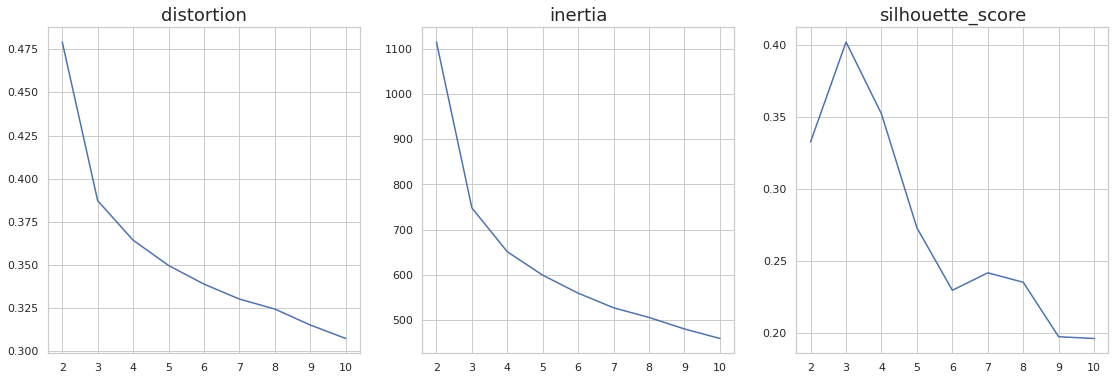

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(19,6))
ax[0].plot(kmean_score_df.n_clusters, kmean_score_df.distortion)
ax[1].plot(kmean_score_df.n_clusters, kmean_score_df.inertia)
ax[2].plot(kmean_score_df.n_clusters, kmean_score_df.silhouette_score)
ax[0].set_title('distortion', fontsize=18)
ax[1].set_title('inertia', fontsize=18)
ax[2].set_title('silhouette_score', fontsize=18)

In [ ]:
kmean_model = KMeans(n_clusters=3, random_state=0).fit(features_train)
label_kmean = kmean_model.labels_

In [ ]:
pd.Series(label_kmean).value_counts()

0    1561
1    1393
2    1176
dtype: int64

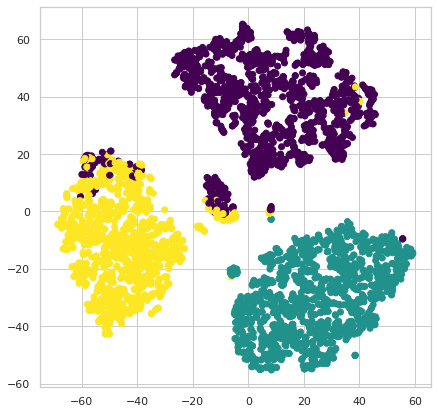

In [ ]:
x_plot = TSNE(n_components=2, learning_rate='auto', random_state=20).fit_transform(features_train)
plt.figure(figsize=(7,7))
plt.scatter(x_plot[:,0], x_plot[:,1],c=label_kmean, cmap='viridis')

In [ ]:
gmm_score_df = pd.DataFrame(columns=['n_clusters', 'BIC', 'AIC', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'])
for i in range(2,11):
    gm = GaussianMixture(n_components=i, random_state=123)
    gm.fit(features_train)
    labels = gm.predict(features_train)
    bic = gm.bic(features_train)
    aic = gm.aic(features_train)

    silhouette = silhouette_score(features_train, labels)
    calinski_harabasz = calinski_harabasz_score(features_train, labels)
    davies_bouldin = davies_bouldin_score(features_train, labels)

    to_append = pd.DataFrame([[i, bic, aic, silhouette, calinski_harabasz, davies_bouldin]],
                             columns=['n_clusters', 'BIC', 'AIC', 'silhouette_score', 'calinski_harabasz_score', 'davies_bouldin_score'])
    gmm_score_df = pd.concat([gmm_score_df,to_append])

Text(0.5, 1.0, 'silhouette_score')

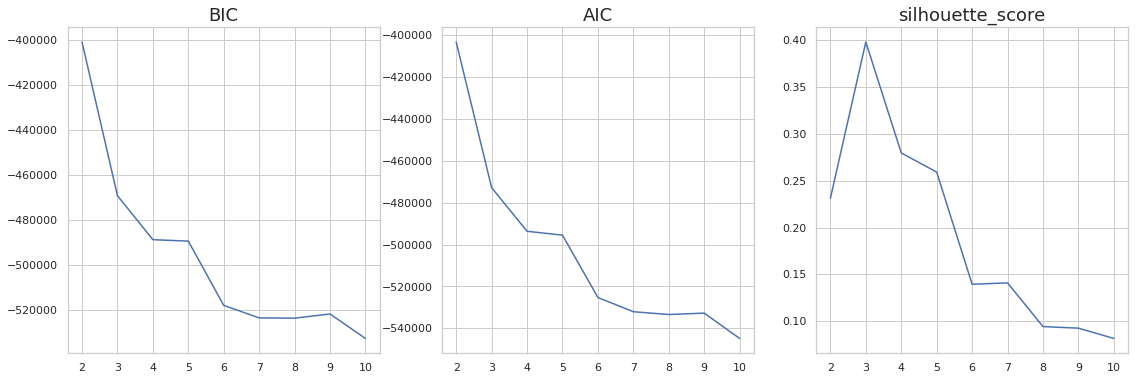

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(19,6))
ax[0].plot(gmm_score_df.n_clusters, gmm_score_df.BIC)
ax[1].plot(gmm_score_df.n_clusters, gmm_score_df.AIC)
ax[2].plot(gmm_score_df.n_clusters, gmm_score_df.silhouette_score)
ax[0].set_title('BIC', fontsize=18)
ax[1].set_title('AIC', fontsize=18)
ax[2].set_title('silhouette_score', fontsize=18)

In [ ]:
gmm_model = GaussianMixture(n_components=3, random_state=123, n_init=10)
label_gmm = gmm_model.fit_predict(features_train)

In [ ]:
pd.Series(label_gmm).value_counts()

1    1540
0    1397
2    1193
dtype: int64

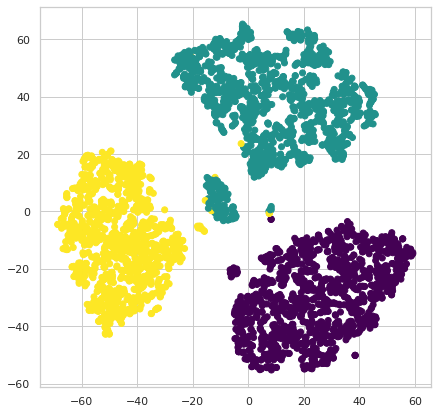

In [ ]:
plt.figure(figsize=(7,7))
plt.scatter(x_plot[:,0], x_plot[:,1],c=label_gmm, cmap='viridis')

Text(0, 0.5, 'Mean decrease in impurity')

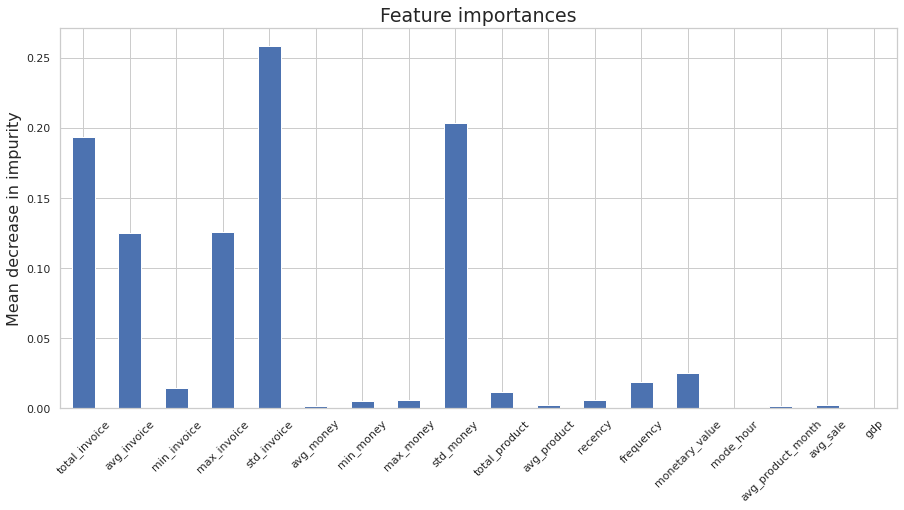

In [ ]:
y_train2 = pd.Series(label_gmm).copy(deep=True)

clf = RandomForestClassifier(min_samples_leaf=2, random_state=21).fit(features_train, y_train2)
importances = clf.feature_importances_
feature_names = x_train.columns[:-1]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15, 7))
forest_importances.plot.bar(ax=ax, rot=45)
ax.set_title("Feature importances", fontsize=19)
ax.set_ylabel("Mean decrease in impurity", fontsize=16)

In [ ]:
x2 = x[['total_invoice', 'avg_invoice', 'min_invoice', 'max_invoice', 'std_invoice', 'std_money', 'frequency', 'monetary_value', 'year']]

In [ ]:
x_train2 = x2[x2.year == 2010].iloc[:, :-1]
x_test2 = x2[x2.year == 2011].iloc[:, :-1]

In [ ]:
features2 = pd.DataFrame(feature_scaling(x2))

In [ ]:
features2

,0,1,2,3,4,5,6,7,8
0,0.132845,0.000000,0.0,0.000000,0.000000,0.709393,0.356100,0.413646,0.0
1,0.132845,0.000000,0.0,0.000000,0.000000,0.831868,0.518272,0.632782,0.0
2,0.132845,0.000000,0.0,0.000000,0.000000,0.666270,0.360675,0.485880,0.0
3,0.132845,0.000000,0.0,0.000000,0.000000,0.751047,0.514926,0.634762,0.0
4,0.000000,0.000000,0.0,0.000000,0.726591,0.433334,0.341134,0.464312,0.0
...,...,...,...,...,...,...,...,...,...
8260,0.000000,0.000000,0.0,0.000000,0.726591,0.433334,0.257981,0.419309,1.0
8261,0.000000,0.000000,0.0,0.000000,0.726591,0.433334,0.218008,0.348441,1.0
8262,0.132845,0.000000,0.0,0.000000,0.000000,0.606550,0.278414,0.418056,1.0
8263,0.531585,0.156816,0.0,0.368474,0.723071,0.755122,0.742485,0.635083,1.0


In [ ]:
features_train2 = features2[features2.iloc[:,-1] == 0]
feature_test2 = features2[features2.iloc[:,-1] == 1]

In [ ]:
x2[x2.year == 2010].iloc[:, :-1]

,total_invoice,avg_invoice,min_invoice,max_invoice,std_invoice,std_money,frequency,monetary_value
CustomerID,,,,,,,,
12346_2010,2,1.000000,1,1,0.00000,81.501128,24,169.36
12347_2010,2,1.000000,1,1,0.00000,574.206062,102,2035.11
12348_2010,2,1.000000,1,1,0.00000,40.983909,25,384.36
12349_2010,2,1.000000,1,1,0.00000,158.321208,99,2081.34
12351_2010,1,1.000000,1,1,NaN,NaN,21,300.93
...,...,...,...,...,...,...,...,...
18283_2010,6,1.500000,1,2,0.57735,77.405182,230,641.77
18284_2010,1,1.000000,1,1,NaN,NaN,27,411.68
18285_2010,1,1.000000,1,1,NaN,NaN,10,173.00


Text(0.5, 1.0, 'silhouette_score')

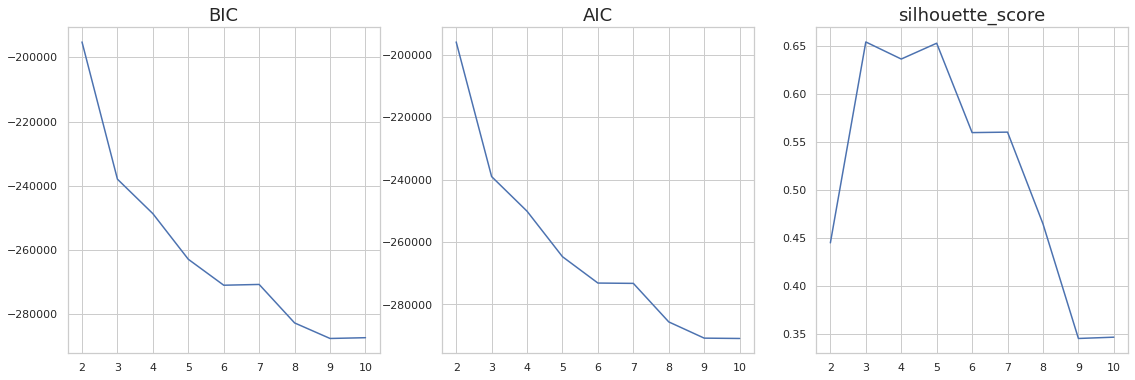

In [ ]:
gmm_score_df = pd.DataFrame(
    columns=['n_clusters', 'BIC', 'AIC', 'silhouette_score'])
for i in range(2, 11):
    gm = GaussianMixture(n_components=i, random_state=123)
    gm.fit(features_train2)
    labels = gm.predict(features_train2)

    bic = gm.bic(features_train2)
    aic = gm.aic(features_train2)
    silhouette = silhouette_score(features_train2, labels)


    to_append = pd.DataFrame([[i, bic, aic, silhouette]],
                             columns=['n_clusters', 'BIC', 'AIC', 'silhouette_score'])
    gmm_score_df = pd.concat([gmm_score_df, to_append])

fig, ax = plt.subplots(1, 3, figsize=(19, 6))
ax[0].plot(gmm_score_df.n_clusters, gmm_score_df.BIC)
ax[1].plot(gmm_score_df.n_clusters, gmm_score_df.AIC)
ax[2].plot(gmm_score_df.n_clusters, gmm_score_df.silhouette_score)
ax[0].set_title('BIC', fontsize=18)
ax[1].set_title('AIC', fontsize=18)
ax[2].set_title('silhouette_score', fontsize=18)

In [ ]:
gmm_model = GaussianMixture(n_components=3, random_state=123, n_init=10)
label_gmm = gmm_model.fit_predict(features_train2)

In [ ]:
pd.Series(label_gmm).value_counts()

2    1540
1    1397
0    1193
dtype: int64

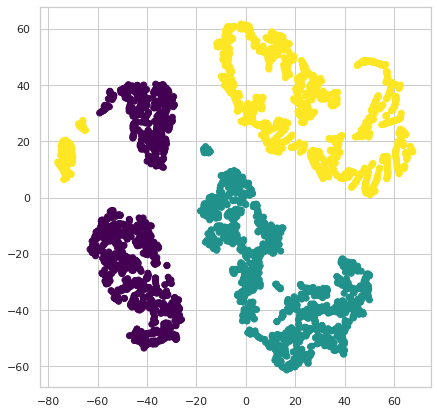

In [ ]:
x_plot3 = TSNE(n_components=2, learning_rate='auto', random_state=20).fit_transform(features_train2)
plt.figure(figsize=(7,7))
plt.scatter(x_plot3[:,0], x_plot3[:,1],c=label_gmm, cmap='viridis')

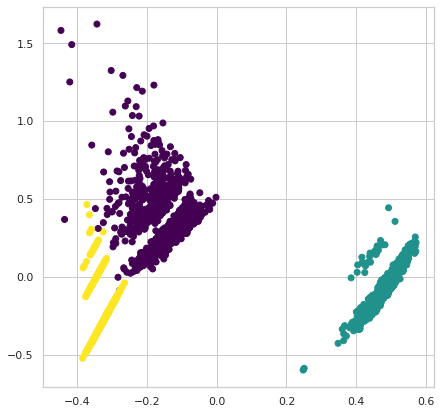

In [ ]:
x_plot3 = PCA(n_components=2, random_state=20).fit_transform(features_train2)
plt.figure(figsize=(7,7))
plt.scatter(x_plot3[:,0], x_plot3[:,1],c=label_gmm, cmap='viridis')

In [ ]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class ComplexRadar():
    def __init__(self, fig, variables, ranges,n_ordinate_levels=5):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i))
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles,
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle
             in zip(text, angles)]

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)

        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2))
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(0, 1, title, transform = self.ax.transAxes, *args, **kw)

In [ ]:
variables = x2.columns[:-1]
ranges = [(0, 10), (0,3), (0, 3),
          (0, 3), (0, 1), (0, 500),
          (0, 250), (0,6000)]

In [ ]:
x_train2.fillna(0,inplace=True)
x_test2.fillna(0,inplace=True)

In [ ]:
def plot_clusters(cluster):
    fig = plt.figure(figsize=(7, 7))
    dt = x_train2[label_gmm==cluster]
    radar = ComplexRadar(fig, variables, ranges)
    radar.plot(dt.mean())
    radar.fill(dt.mean(), alpha=0.2)
    radar.title(f"Cluster {cluster}\n{dt.shape[0]} Customers", c='r', fontsize=20)
    plt.show()

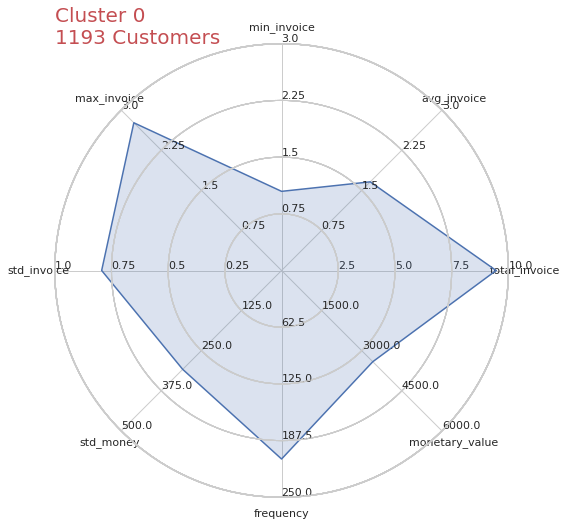

In [ ]:
plot_clusters(0)

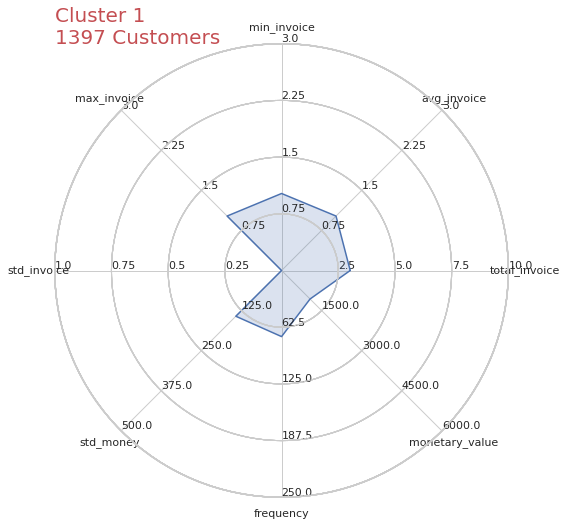

In [ ]:
plot_clusters(1)

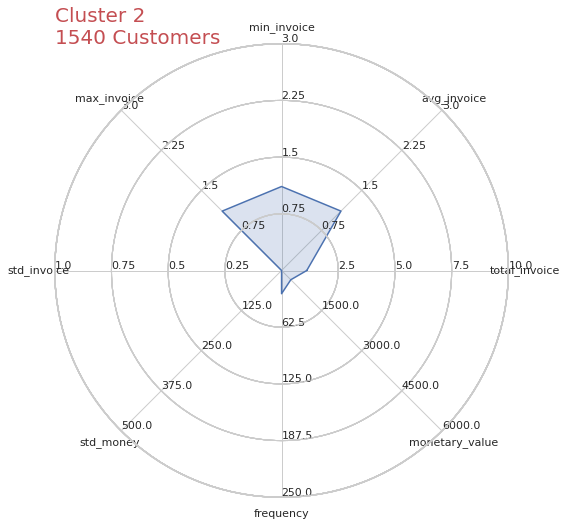

In [ ]:
plot_clusters(2)

# Test set (2011)

In [ ]:
label_test = gmm_model.predict(feature_test2)

In [ ]:
pd.Series(label_test).value_counts()

2    1620
1    1443
0    1072
dtype: int64

In [ ]:
def plot_clusters2(cluster):
    fig = plt.figure(figsize=(7, 7))
    dt = x_test2[label_test==cluster]
    radar = ComplexRadar(fig, variables, ranges)
    radar.plot(dt.mean())
    radar.fill(dt.mean(), alpha=0.2)
    radar.title(f"Cluster {cluster}\n{dt.shape[0]} Customers", c='r', fontsize=20)
    plt.show()

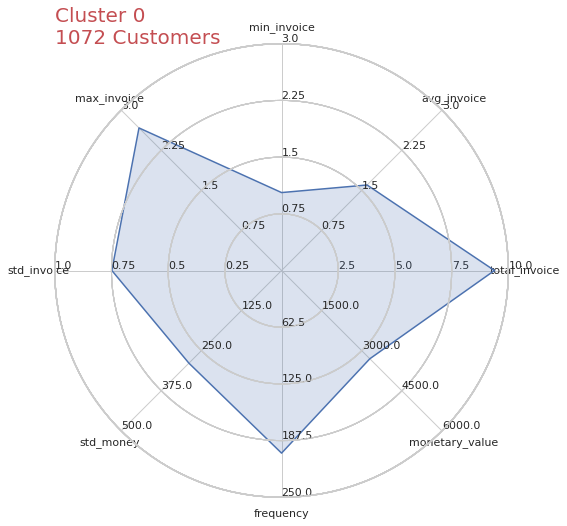

In [ ]:
plot_clusters2(0)

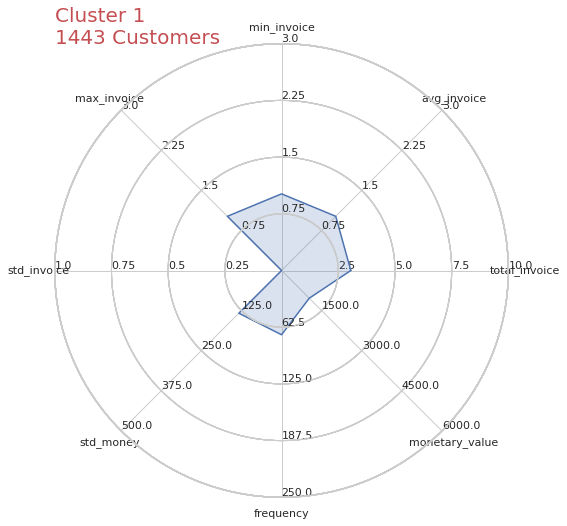

In [ ]:
plot_clusters2(1)

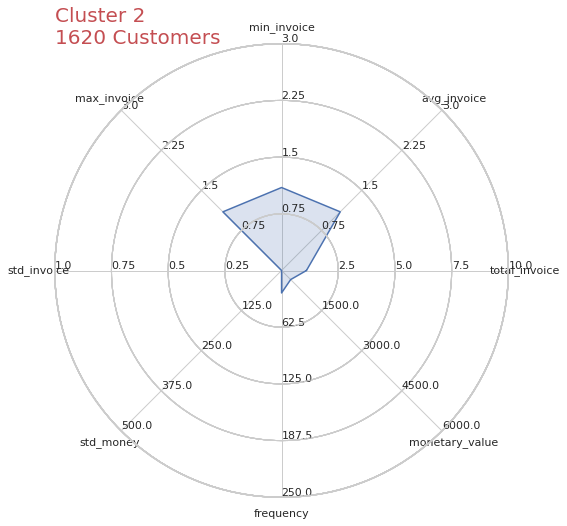

In [ ]:
plot_clusters2(2)

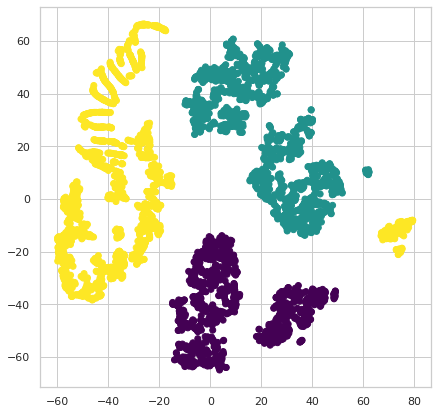

In [ ]:
x_plot3 = TSNE(n_components=2, learning_rate='auto', random_state=20).fit_transform(feature_test2)
plt.figure(figsize=(7,7))
plt.scatter(x_plot3[:,0], x_plot3[:,1],c=label_test, cmap='viridis')

In [ ]:
new_df_train = x_train2.copy()
new_df_train.index = pd.Series(x_train2.index).str.split('_', n=1, expand=True)[0]
new_df_train['label_2010'] = label_gmm

new_df_test = x_test2.copy()
new_df_test.index = pd.Series(x_test2.index).str.split('_', n=1, expand=True)[0]
new_df_test['label_2011'] = label_test

In [ ]:
comparison = pd.merge(new_df_train, new_df_test, left_index=True, right_index=True,how='outer')[['label_2010', 'label_2011']]
comparison

,label_2010,label_2011
0,,
12346,1.0,NaN
12347,1.0,1.0
12348,1.0,1.0
12349,1.0,2.0
12350,NaN,2.0
...,...,...
18283,0.0,0.0
18284,2.0,NaN
18285,2.0,NaN


#5. Business Metric

* Trong 10% khách hàng co monetary value cao nhất 2011 thì bao nhiêu khách hàng thuộc nhóm Golden của 2 phương pháp
* Trong số cacs khách hàng mua liên tục 6 tháng liên tiếp ở năm 2011 thì bao nhiêu % thuộc nhóm Golden của 2 phương pháp

## Kmeans + GMM

In [ ]:
x_test2

,total_invoice,avg_invoice,min_invoice,max_invoice,std_invoice,std_money,frequency,monetary_value
CustomerID,,,,,,,,
12347_2011,6,1.00,1,1,0.000000,372.035229,149,3328.81
12348_2011,2,1.00,1,1,0.000000,2.404163,2,37.40
12349_2011,1,1.00,1,1,0.000000,0.000000,71,1417.60
12350_2011,1,1.00,1,1,0.000000,0.000000,16,294.40
12352_2011,7,1.75,1,3,0.957427,120.042154,77,1385.74
...,...,...,...,...,...,...,...,...
18280_2011,1,1.00,1,1,0.000000,0.000000,10,180.60
18281_2011,1,1.00,1,1,0.000000,0.000000,7,80.82
18282_2011,2,1.00,1,1,0.000000,15.817979,12,178.05


In [ ]:
len(x_test2)*0.1

413.5

In [ ]:
# 10% khach hang co monetary value cao nhat 2011
x_test2.sort_values(by='monetary_value', ascending=False)[:413]

,total_invoice,avg_invoice,min_invoice,max_invoice,std_invoice,std_money,frequency,monetary_value
CustomerID,,,,,,,,
14911_2011,184,15.333333,4,34,9.028574,5772.375469,5162,112499.05
14646_2011,55,4.583333,1,10,2.678478,2421.101021,763,55632.03
14096_2011,17,3.400000,1,6,2.302173,8376.424970,5042,50462.74
13089_2011,85,7.083333,4,12,2.151462,925.875631,1692,45977.01
14156_2011,48,4.363636,1,7,1.858641,2123.526465,1073,43348.93
...,...,...,...,...,...,...,...,...
14543_2011,15,1.666667,1,3,0.866025,199.408187,63,3064.28
13266_2011,12,1.333333,1,2,0.500000,121.027471,171,3057.04
16678_2011,12,1.500000,1,3,0.755929,134.719274,160,3056.05


In [ ]:
x_test2.sort_values(by='monetary_value', ascending=False)[:413].index.isin(x_test2[label_test==0].index).sum()

351

In [ ]:
351 / 413

0.8498789346246973

**Comment:** 413 khách hàng thuộc nhóm 10% chi nhiều tiền nhất năm 2011
Trong 413 người này thì có 351 người (84%) thuộc cluster 0 (cluster golden customer)

In [ ]:
test_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalValue,year,month,day,hour,year_month
567942,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,19.50,2011,1,4,10,2011-1
567943,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.50,2011,1,4,10,2011-1
567944,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.50,2011,1,4,10,2011-1
567945,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom,10.50,2011,1,4,10,2011-1
567946,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom,12.50,2011,1,4,10,2011-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067365,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011,12,9,12,2011-12
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011,12,9,12,2011-12
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,9,12,2011-12
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011,12,9,12,2011-12


In [ ]:
all_month = test_df.groupby('CustomerID').month.nunique()

In [ ]:
all_month[all_month > 6]

CustomerID
12362.0     8
12395.0     7
12415.0     9
12417.0     7
12423.0     7
           ..
18225.0     9
18226.0     9
18229.0    11
18241.0     7
18283.0    10
Name: month, Length: 369, dtype: int64

In [ ]:
golden_index = pd.Series(x_test2[label_test==0].index).str.split('_', n=1, expand=True)[0]

In [ ]:
all_month[all_month > 6].index.isin(golden_index.astype('float64')).sum()

338

In [ ]:
338 / 369

0.9159891598915989

**Comment**: Có 369 khách hàng mua hàng 6/12 tháng ở năm 2011
Trong 369 khách hàng này thì có 338 khách hàng (91%) nằm trong cluster 0 (golden)

## RFM + CLV

In [ ]:
data

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment_rfm,segment_clv,segment
259,13442.0,666,2,175.92,1,2,1,4,Low,Low,low value
270,13223.0,571,2,201.12,1,2,1,4,Low,Low,low value
295,13619.0,543,2,230.19,1,2,1,4,Low,Low,low value
306,13190.0,543,2,166.10,1,2,1,4,Low,Low,low value
397,14279.0,519,2,191.86,1,2,1,4,Low,Low,low value
...,...,...,...,...,...,...,...,...,...,...,...
4125,13448.0,363,7,5011.24,5,5,5,15,High,High,extremely important
4126,17068.0,357,28,4892.64,5,5,5,15,High,High,extremely important
4127,17069.0,353,6,3167.23,5,5,5,15,High,High,extremely important
4128,14907.0,359,11,3607.98,5,5,5,15,High,High,extremely important


In [ ]:
data[data.segment == 'extremely important'].CustomerID

2946    15038.0
2948    15015.0
2949    13362.0
2951    14175.0
2954    13340.0
         ...   
4125    13448.0
4126    17068.0
4127    17069.0
4128    14907.0
4129    13230.0
Name: CustomerID, Length: 989, dtype: float64

In [ ]:
x_test2.sort_values(by='monetary_value', ascending=False)[:413].index.isin(data[data.segment == 'extremely important'].CustomerID)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
pd.Series(x_test2.sort_values(by='monetary_value', ascending=False)[:413].index).str.split('_', n=1, expand=True)[0].astype('float64').isin(data[data.segment == 'extremely important'].CustomerID).sum()

307

In [ ]:
307/413

0.7433414043583535

**Comment:** Có 413 khách hàng này là nhóm 10% chi nhiều tiền nhất 2011
Segment Extremely Important chỉ có 307 người (74%) thuộc nhóm 10% này

In [ ]:
all_month[all_month > 6]

CustomerID
12362.0     8
12395.0     7
12415.0     9
12417.0     7
12423.0     7
           ..
18225.0     9
18226.0     9
18229.0    11
18241.0     7
18283.0    10
Name: month, Length: 369, dtype: int64

In [ ]:
all_month[all_month > 6].index.isin(data[data.segment == 'extremely important'].CustomerID).sum()

282

In [ ]:
282/369

0.7642276422764228

**Comment:** Có 369 khách hàng mua hàng 6/12 tháng ở năm 2011 Trong 369 khách hàng này thì có 282 khách hàng (76%) nằm trong Extremely Important

**KẾT LUẬN**: Sử dụng Business metric ta có thể đánh giá là phương pháp Clustering có kết quả tốt hơn RFM + CLV